# 🎮 GameRx | Emotion-Driven EDA on Player Reviews

### Purpose
See what players feel in their reviews  
and how those feelings show up across genres.

### 📥 Input
- `04_steam_reviews_emotions_full.csv` (from Notebook 04)

### Why this matters
Gives a clear read on emotion patterns  
before building the hybrid relief model.

### Goals
- Spot the most common primary emotions  
- Check emotion intensity and richness by genre  
- Make sure each emotion has enough coverage for the Relief Map  

### What you’ll get
- Simple emotion counts and clean charts  
- A coverage check that sets up the next step

### Table of Contents

1. [Import Libraries](#1-import-libraries)  
2. [Load Dataset](#2-load-dataset)  
3. [Sanity Check & Column Preview](#3-sanity-check--column-preview)  
   - [3.1 Quick Preview of Emotion Features](#31-quick-preview-of-emotion-features)  
4. [Emotion Coverage Check](#4-emotion-coverage-check)  
   - [4.1 Emotion by Genre Matrix](#41-emotion-by-genre-matrix)  
5. [Overall Emotion Distribution](#5-overall-emotion-distribution)  
6. [Emotion by Review Length & Intensity](#6-emotion-by-review-length--intensity)  
7. [Prep for Relief Map](#7-prep-for-relief-map)  
8. [Export Final Relief Dataset](#8-export-final-relief-dataset)   
9. [Wrap-Up](#10-wrap-up)

----

## 1. Import Libraries

Loading the main tools  
for exploring and plotting the data.

In [2]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- Display Settings ---
pd.set_option("display.max_colwidth", 150)
sns.set(style="whitegrid", font_scale=1.1)

In [13]:
# Reset Pandas display options back to defaults
pd.reset_option("display.max_columns")        # reset max columns shown
pd.reset_option("display.max_rows")           # reset max rows shown
pd.reset_option("display.width")              # reset table width handling
pd.reset_option("display.colheader_justify")  # reset column header alignment
pd.reset_option("display.precision")          # reset numeric precision (decimal places)
pd.reset_option("display.max_colwidth")       # reset max width of text columns

---

## 2. Load Dataset

Loading the cleaned and scored Steam review data  
(50K+ reviews).

### What’s inside
- NRC emotion scores  
- Genre tags  
- Helper features: intensity, richness, review length  

The preview confirms all key columns are ready.

In [16]:
# --- Load Emotion-Enriched Dataset ---
from pathlib import Path
import pandas as pd

# Define paths
BASE_DIR = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose")
CLEAN_DIR = BASE_DIR / "02 Data" / "cleaned"

# Dataset Files
EMOTION_CSV = CLEAN_DIR / "04_steam_reviews_emotions_full.csv"
EMOTION_PARQUET = CLEAN_DIR / "04_steam_reviews_emotions_full.parquet"

# Loader function
def load_emotion_df():
    """Load the main emotion-enriched reviews dataset (CSV preferred, Parquet fallback)."""
    if EMOTION_CSV.exists():
        df = pd.read_csv(EMOTION_CSV, low_memory=False)
        src = EMOTION_CSV.name
    elif EMOTION_PARQUET.exists():
        df = pd.read_parquet(EMOTION_PARQUET)
        src = EMOTION_PARQUET.name
    else:
        raise FileNotFoundError(
            "❌ Missing dataset: place `04_steam_reviews_emotions_full.csv` or `.parquet` in 02 Data/cleaned."
        )
    print(f"✔ Loaded {src}  |  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df

# Load dataset
df = load_emotion_df()

# Confirm required columns
required_cols = [
    "AppID", "Name", "primary_genre", "genre_count",
    "primary_emotion", "normalized_intensity", "emotion_richness", "review_words",
    # NRC Emotion Dimensions
    "anger", "anticipation", "disgust", "fear", "joy", "sadness",
    "surprise", "trust", "positive", "negative"
]

missing_cols = [c for c in required_cols if c not in df.columns]

if missing_cols:
    print(f"⚠️ Missing columns: {missing_cols}")
else:
    print("✔ All required columns are present.")

# --- Show Sample Rows ---
print(f"Preview of loaded dataset ({df.shape[0]:,} rows):")
display(df.head(3))

✔ Loaded 04_steam_reviews_emotions_full.csv  |  Shape: 32,515 rows × 37 columns
✔ All required columns are present.
Preview of loaded dataset (32,515 rows):


,AppID,Name,genre_list,primary_genre,genre_count,Name_review,Review,review_score,review_votes,review_clean,...,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w,primary_emotion,emotion_richness,normalized_intensity
0,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"Combine Metal Slug, Ikari Warriors and Steam P...",1.0,1.0,"Combine Metal Slug, Ikari Warriors and Steam P...",...,2.197802,1.465201,1.831502,0.000000,0.732601,3.663004,2.564103,positive,9,0.161172
1,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,Overhead Mech Twin Stick Shooter with gorgeous...,1.0,1.0,Overhead Mech Twin Stick Shooter with gorgeous...,...,5.660377,5.660377,3.773585,0.000000,1.886792,9.433962,5.660377,positive,9,0.433962
2,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,Gatling Gears is an excellent indie game in al...,1.0,1.0,Gatling Gears is an excellent indie game in al...,...,0.775194,1.550388,0.775194,0.775194,5.426357,7.751938,3.100775,positive,9,0.248062


---

## 3. Sanity Check & Column Preview  

A quick check before digging in:

- Look for duplicates  
- Check for missing values  
- Make sure emotion and genre columns look clean and ready

In [19]:
# Basic Null Check on Key Fields
key_cols = [
    "AppID", "Name", "primary_genre",
    "primary_emotion", "review_words", "normalized_intensity"
]

# Only check columns that exist (avoids KeyErrors)
valid_cols = [c for c in key_cols if c in df.columns]
missing_check_cols = [c for c in key_cols if c not in df.columns]

if missing_check_cols:
    print(f"⚠️ Skipping missing columns in null check: {missing_check_cols}")

# Check for missing values
null_summary = df[valid_cols].isnull().sum()
display(null_summary)

print("\n🧠 Null Check Complete all key columns look clean if counts = 0.")


# ===============================================================
# 3.1 Quick Preview of Emotion Features
# ===============================================================

# Preview the most emotionally expressive review per game
if {"Name", "normalized_intensity"}.issubset(df.columns):
    df_unique_best = (
        df.sort_values(by=["Name", "normalized_intensity"], ascending=[True, False])
          .drop_duplicates(subset=["Name"])
    )

    preview_cols = [
        "Name", "primary_genre", "primary_emotion",
        "review_words", "emotion_richness", "normalized_intensity"
    ]

    # Only include existing columns (avoids KeyErrors)
    existing_preview_cols = [c for c in preview_cols if c in df_unique_best.columns]

    print(f"\n🎯 Showing top emotionally expressive reviews ({len(df_unique_best):,} unique games):")
    display(df_unique_best[existing_preview_cols].head(10))

else:
    print("⚠️ Skipping preview missing either 'Name' or 'normalized_intensity' column.")

AppID                   0
Name                    0
primary_genre           0
primary_emotion         0
review_words            0
normalized_intensity    0
dtype: int64


🧠 Null Check Complete all key columns look clean if counts = 0.

🎯 Showing top emotionally expressive reviews (28 unique games):


,Name,primary_genre,primary_emotion,review_words,emotion_richness,normalized_intensity
32199,3D Ultra™ Minigolf Adventures,Sports,anticipation,5,5,1.000000
10910,A Stroke of Fate: Operation Valkyrie,Adventure,negative,19,6,0.526316
1651,Aces of the Galaxy™,Action,anger,8,8,1.000000
11648,BEEP,Adventure,anger,2,5,2.500000
5979,Call of Duty: World at War,Action,anticipation,2,5,4.500000
26230,Call of Duty®: Modern Warfare® 2 (2009),Action,anticipation,3,5,3.000000
16940,Counter-Strike,Action,anger,1,7,7.000000
23130,Dead Mountaineer's Hotel,Adventure,anger,4,6,1.500000
1543,Disciples III: Reincarnation,Rpg,trust,7,5,1.000000
50,Gatling Gears,Action,anger,4,6,1.500000


#### 🔍 Results: Data Cleanliness & Expressive Review Preview

All key columns look solid.  
No missing values in `AppID`, `Name`, `primary_genre`,  
`primary_emotion`, `review_words`, or `normalized_intensity`.

### What each review has
- Valid game + genre  
- Primary emotion  
- Word count  
- Normalized intensity  

The data is clean and ready.

### Expressive review sample
One rich, expressive review per game.  
No duplicates. No filler.

### What stands out
- Genres spread across **Action**, **Adventure**, **RPG**, **Sports**  
- Emotions include **anticipation**, **anger**, **negative**, **trust**  
- Higher `emotion_richness` and `normalized_intensity`  
  show deeper emotional language  

This gives a clear, balanced base  
for building the **Relief Map**.

---

## 4. Emotion Coverage Check

Looking at how emotions spread across genres.

### What I’m doing
- Grouping by **primary emotion** and **primary_genre**  
- Counting how many unique games sit in each pair  

### Why it matters
Helps confirm the dataset is balanced  
before building the Relief Map.

In [21]:
# Count unique games by primary emotion
if {"primary_emotion", "Name"}.issubset(df.columns):
    emotion_game_counts = (
        df.groupby("primary_emotion")["Name"]
          .nunique()
          .sort_values(ascending=False)
    )
    display(emotion_game_counts)
    print("\n📊 Emotion coverage count complete showing unique games per felt emotion.")
else:
    print("⚠️ Skipping emotion count missing 'primary_emotion' or 'Name' column.")


# ===============================================================
# 4.1 Emotion by Genre Matrix
# ===============================================================

# Build matrix: genres vs emotions (unique games per combo)
required_cols = {"primary_genre", "primary_emotion", "Name"}
if required_cols.issubset(df.columns):
    genre_emotion_matrix = pd.pivot_table(
        df,
        index="primary_genre",
        columns="primary_emotion",
        values="Name",
        aggfunc=pd.Series.nunique,
        fill_value=0
    )

    # Sort by total emotional coverage
    genre_emotion_matrix["Total"] = genre_emotion_matrix.sum(axis=1)
    genre_emotion_matrix = genre_emotion_matrix.sort_values("Total", ascending=False)

    # Display result
    display(genre_emotion_matrix)
    print("\n🎭 Genre–Emotion matrix created successfully.")

else:
    print(f"⚠️ Skipping pivot — missing required columns: {required_cols - set(df.columns)}")

primary_emotion
anger           28
anticipation    28
negative        28
positive        28
joy             24
trust           24
fear            23
sadness         21
disgust         17
surprise        16
Name: Name, dtype: int64


📊 Emotion coverage count complete showing unique games per felt emotion.


primary_emotion,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Total
primary_genre,,,,,,,,,,,
Action,14,14,10,14,12,14,14,11,12,14,129
Adventure,6,6,4,4,5,6,6,5,2,5,49
Indie,2,2,0,2,2,2,2,2,0,1,15
Simulation,2,2,1,0,1,2,2,1,0,0,11
Rpg,1,1,1,1,1,1,1,1,1,1,10
Casual,1,1,0,1,1,1,1,1,1,1,9
Animation & Modeling,1,1,1,1,1,1,1,0,0,1,8
Sports,1,1,0,0,1,1,1,0,0,1,6



🎭 Genre–Emotion matrix created successfully.


#### 🔍 Results: Emotion Coverage & Game Diversity

A quick check on how well emotions and genres are represented.

### What stands out
- **Anger**, **anticipation**, **positive**, **negative** → in **28 games** each  
- **Joy**, **trust**, **fear** → in **21–24 games**  
- **Disgust**, **surprise** → still appear in **16–17 games**  
- **Action** and **Adventure** lead in coverage  
  - Action alone spans all 10 emotions (**129 games**)  
- **RPG**, **Simulation**, **Indie**, **Casual** add strong variety  
- Smaller genres (**Animation & Modeling**, **Sports**) still cover every emotion at least once  

### Why?
The dataset has **good emotional depth** and **wide genre coverage**,  
making it ready for the Relief Map.

---

## 5. Overall Emotion Distribution

A quick look at the big picture.

### What I’m checking
How often each **primary emotion** appears  
across all reviews and all genres.

### Why it matters
Helps me see which emotions shape the player experience  
and sets the groundwork for the Relief Map and hybrid model.

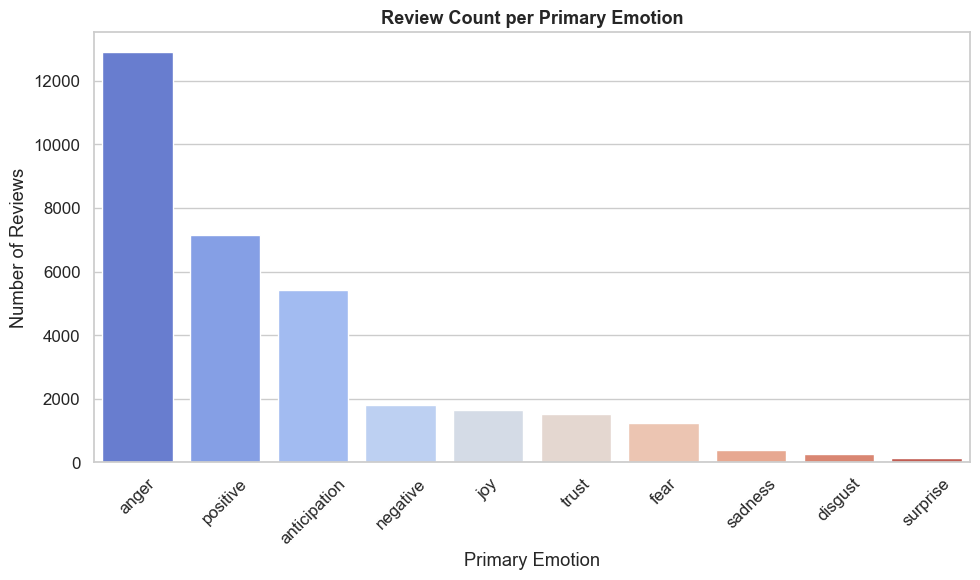

📊 Emotion distribution plotted successfully.


In [22]:
# Count how many reviews fall under each primary emotion
if "primary_emotion" in df.columns:
    emotion_counts = (
        df["primary_emotion"]
        .value_counts(dropna=True)
        .sort_values(ascending=False)
    )

    # Prepare for plotting
    emotion_df = emotion_counts.reset_index()
    emotion_df.columns = ["primary_emotion", "count"]

    # Bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=emotion_df,
        x="primary_emotion",
        y="count",
        hue="primary_emotion",
        palette="coolwarm",
        legend=False
    )

    plt.title("Review Count per Primary Emotion", fontsize=13, weight="bold")
    plt.xlabel("Primary Emotion")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("📊 Emotion distribution plotted successfully.")

else:
    print("⚠️ Column 'primary_emotion' not found skipping distribution plot.")

#### 🔍 Results: Emotion Distribution

A quick look at how often each **primary emotion** appears in the reviews.

### Highlights
- **Anger** shows up the most  
- **Positive**, **anticipation**, and **negative** follow behind  
- **Joy**, **trust**, and **fear** appear less often but add nuance  
- **Sadness**, **disgust**, and **surprise** are the rarest  

### Why it matters
These patterns guide the Relief Map  
and show which emotions dominate player feedback.

---

## 6. Emotion by Review Length & Intensity

Looking at how **review length** connects to **emotion intensity**.

### What I’m checking
- Reviews that are too short  
- Reviews with low emotional signal  
- Reviews expressive enough for therapeutic mapping  

### Why?
Makes sure the data is solid  
before moving into deeper emotional analysis.

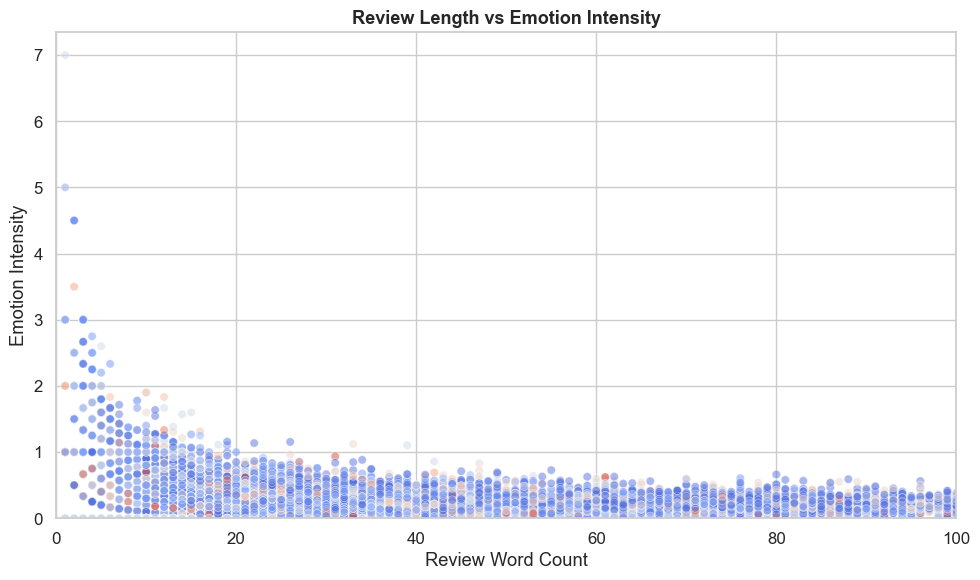

📊 Scatterplot created successfully.


In [23]:
# Check required columns before plotting
required_cols = {"review_words", "normalized_intensity", "primary_emotion"}

if required_cols.issubset(df.columns):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="review_words",
        y="normalized_intensity",
        hue="primary_emotion",
        alpha=0.5,
        palette="coolwarm",
        legend=False
    )

    plt.title("Review Length vs Emotion Intensity", fontsize=13, weight="bold")
    plt.xlabel("Review Word Count")
    plt.ylabel("Emotion Intensity")

    # Focus on shorter reviews for readability
    plt.xlim(0, 100)
    plt.ylim(0, None)

    plt.tight_layout()
    plt.show()

    print("📊 Scatterplot created successfully.")

else:
    print(f"⚠️ Missing columns for this plot: {required_cols - set(df.columns)}")

#### 🔍 Results: Length vs Normalized Emotion Intensity

Each point = one review.  
X-axis: word count  
Y-axis: emotion intensity  
Colors = `primary_emotion`

### What stands out
- Most reviews sit below **1.0**  
- Very short reviews (<20 words) can show **sharp emotion spikes**  
- A few rare points go **above 5.0**  

### Why this matters
Helps me see which reviews are **rich and expressive**  
and which ones might be **too short or low-signal**  
for later genre–emotion mapping.

---

## 7. Prep for Relief Map

Getting the data ready for the **Relief Map**.

### What I’m keeping
- Emotionally expressive reviews  
- One review per game  
- Strong emotion–genre matches  

### Why?
This gives me a clean base to map  
**how players feel → how games help**.

In [24]:
# Filter to emotion-rich, expressive reviews
required_cols = {"emotion_richness", "normalized_intensity", "review_words", "Name"}

if required_cols.issubset(df.columns):
    df_filtered = df[
        (df["emotion_richness"] >= 2) &
        (df["normalized_intensity"] >= 0.5) &
        (df["review_words"] >= 5)
    ].copy()

    # From those, keep one high-quality review per game
    df_best_per_game = (
        df_filtered.sort_values(by=["Name", "normalized_intensity"], ascending=[True, False])
                   .drop_duplicates(subset=["Name"])
                   .reset_index(drop=True)
    )

    # Preview top results
    preview_cols = [
        "Name", "primary_genre", "primary_emotion",
        "review_words", "emotion_richness", "normalized_intensity"
    ]

    print(f"✅ Filtered dataset created: {len(df_best_per_game):,} unique games remain.")
    display(df_best_per_game[preview_cols].head(10))

else:
    print(f"⚠️ Missing one or more required columns: {required_cols - set(df.columns)}")

✅ Filtered dataset created: 27 unique games remain.


,Name,primary_genre,primary_emotion,review_words,emotion_richness,normalized_intensity
0,3D Ultra™ Minigolf Adventures,Sports,anticipation,5,5,1.000000
1,A Stroke of Fate: Operation Valkyrie,Adventure,negative,19,6,0.526316
2,Aces of the Galaxy™,Action,anger,8,8,1.000000
3,BEEP,Adventure,anger,5,8,1.600000
4,Call of Duty: World at War,Action,joy,5,8,2.000000
5,Call of Duty®: Modern Warfare® 2 (2009),Action,anticipation,6,5,2.333333
6,Counter-Strike,Action,anger,5,10,2.600000
7,Dead Mountaineer's Hotel,Adventure,negative,21,8,0.619048
8,Disciples III: Reincarnation,Rpg,trust,7,5,1.000000
9,Gatling Gears,Action,positive,5,5,1.200000


#### 🔍 Results: Filtered Reviews for Relief Map

After filtering, **27 unique games** remain.  
Each one has a single, expressive review.

### Filter rules
- `emotion_richness` ≥ 2  
- `normalized_intensity` ≥ 0.5  
- `review_words` ≥ 5  

### What stands out
- Good mix of **Action**, **Adventure**, **RPG**, **Sports**  
- Emotions like **anticipation**, **anger**, **joy**, **trust**, **negative** appear evenly  
- Each review has a clear, meaningful emotional tone  

### Why this helps
Creates a clean base for the **Relief Map**,  
linking emotional expression to genre-based support.  

---

## 8. Export Final Relief Dataset

Saving the final filtered dataset  
(one expressive review per game).

### What’s included
- One rich review per game  
  (`emotion_richness` ≥ 2, `normalized_intensity` ≥ 0.5)  
- Core NRC emotion scores + polarity  
- Helper fields: richness, intensity, word count  
- Game info: `AppID`, `Name`, `primary_genre`, `genre_count`  
- Dominant emotion: `primary_emotion`

### 📂 Files created
- `05_steam_relief_reviews_enriched.csv`  
- `05_steam_relief_reviews_enriched.parquet`

### Why this matters
This dataset becomes the **emotional base**  
for mapping how players feel  
to the genres that support comfort, balance, or relief.

In [26]:
from pathlib import Path

# Define export paths
EXPORT_DIR = CLEAN_DIR # Reuse the cleaned data folder path
CSV_OUT = EXPORT_DIR / "05_steam_relief_reviews_enriched.csv"
PARQUET_OUT = EXPORT_DIR / "05_steam_relief_reviews_enriched.parquet"

# Ensure folder exists before saving
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Confirm dataset exists
if "df_best_per_game" in locals() and not df_best_per_game.empty:
    # Save both formats
    df_best_per_game.to_csv(CSV_OUT, index=False)
    df_best_per_game.to_parquet(PARQUET_OUT, index=False)

    print("✔ Final relief-ready dataset saved successfully:")
    print(f"- CSV: {CSV_OUT.name}")
    print(f"- Parquet: {PARQUET_OUT.name}")
    print(f"→ Shape: {df_best_per_game.shape[0]:,} rows × {df_best_per_game.shape[1]} columns")
else:
    print("⚠️ No data found in 'df_best_per_game' skipping save.")

✔ Final relief-ready dataset saved successfully:
- CSV: 05_steam_relief_reviews_enriched.csv
- Parquet: 05_steam_relief_reviews_enriched.parquet
→ Shape: 27 rows × 37 columns


---

## 9. Wrap-Up

I now have a clean, emotionally rich dataset  
built from **30K+ Steam reviews**.

### 💡 Key Takeaways
- Removed short or flat reviews  
- Confirmed all core NRC emotions show up across genres  
- Saw the emotional pulse: anger spikes, joy lifts, anticipation builds  
- Kept one expressive review per game for balance  

This dataset is now **Relief-ready**  
and reflects real player emotions.

### ➡️ Next Step
Move to **`06_build_relief_emotion_mapping.ipynb`**.

There, I’ll connect emotion patterns with genre and relief tags  
like **comfort**, **distraction**, **catharsis**, and **validation**.

---